Shanghai Metro Data Acquisition

In [5]:
import requests
import csv
from datetime import datetime

# Overpass API query
overpass_query = """
[out:json];
area["name"="上海市"]->.shanghai;
(
    node["railway"="station"](area.shanghai);
    node["station"="subway"](area.shanghai);
);
out center;
"""

# Request Overpass API
url = "https://overpass-api.de/api/interpreter"
try:
    response = requests.post(url, data={'data': overpass_query})
    response.raise_for_status()  # Check if request was successful
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
    exit()

# Extract data
stations = []
for element in data['elements']:
    if 'tags' in element and 'name' in element['tags']:
        stations.append({
            "name": element['tags']['name'],
            "line": element['tags'].get('line', ""),  # Line information (if available)
            "latitude": element.get('lat', element.get('center', {}).get('lat')),
            "longitude": element.get('lon', element.get('center', {}).get('lon'))
        })

# Export to CSV
csv_filename = f"shanghai_metro_stations.csv"
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['name', 'line', 'latitude', 'longitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(stations)

print(f"Successfully exported {len(stations)} station records to {csv_filename}")

Successfully exported 352 station records to shanghai_metro_stations.csv


The data was found to be messy and incomplete, so it needed to be converted into xlsx format for manual editing.

In [6]:
import pandas as pd

# Read CSV file
df = pd.read_csv("shanghai_metro_stations.csv")

# Save as XLSX file
output_filename = "shanghai_metro_stations.xlsx"
df.to_excel(output_filename, index=False, engine="openpyxl")

print(f"File successfully converted to {output_filename}")

File successfully converted to shanghai_metro_stations.xlsx


Convert the processed xlsx file back to csv.

In [1]:
import pandas as pd

# Read XLSX file
input_filename = "shanghai_metro_rearranged.xlsx"
df = pd.read_excel(input_filename, engine='openpyxl')

# # Save as CSV file（UTF-8）
output_filename = "shanghai_metro_rearranged.csv"
df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"File successfully converted to {output_filename}")

File successfully converted to shanghai_metro_rearranged.csv


Visualize the sorted data and check whether the adjusted data is correct.

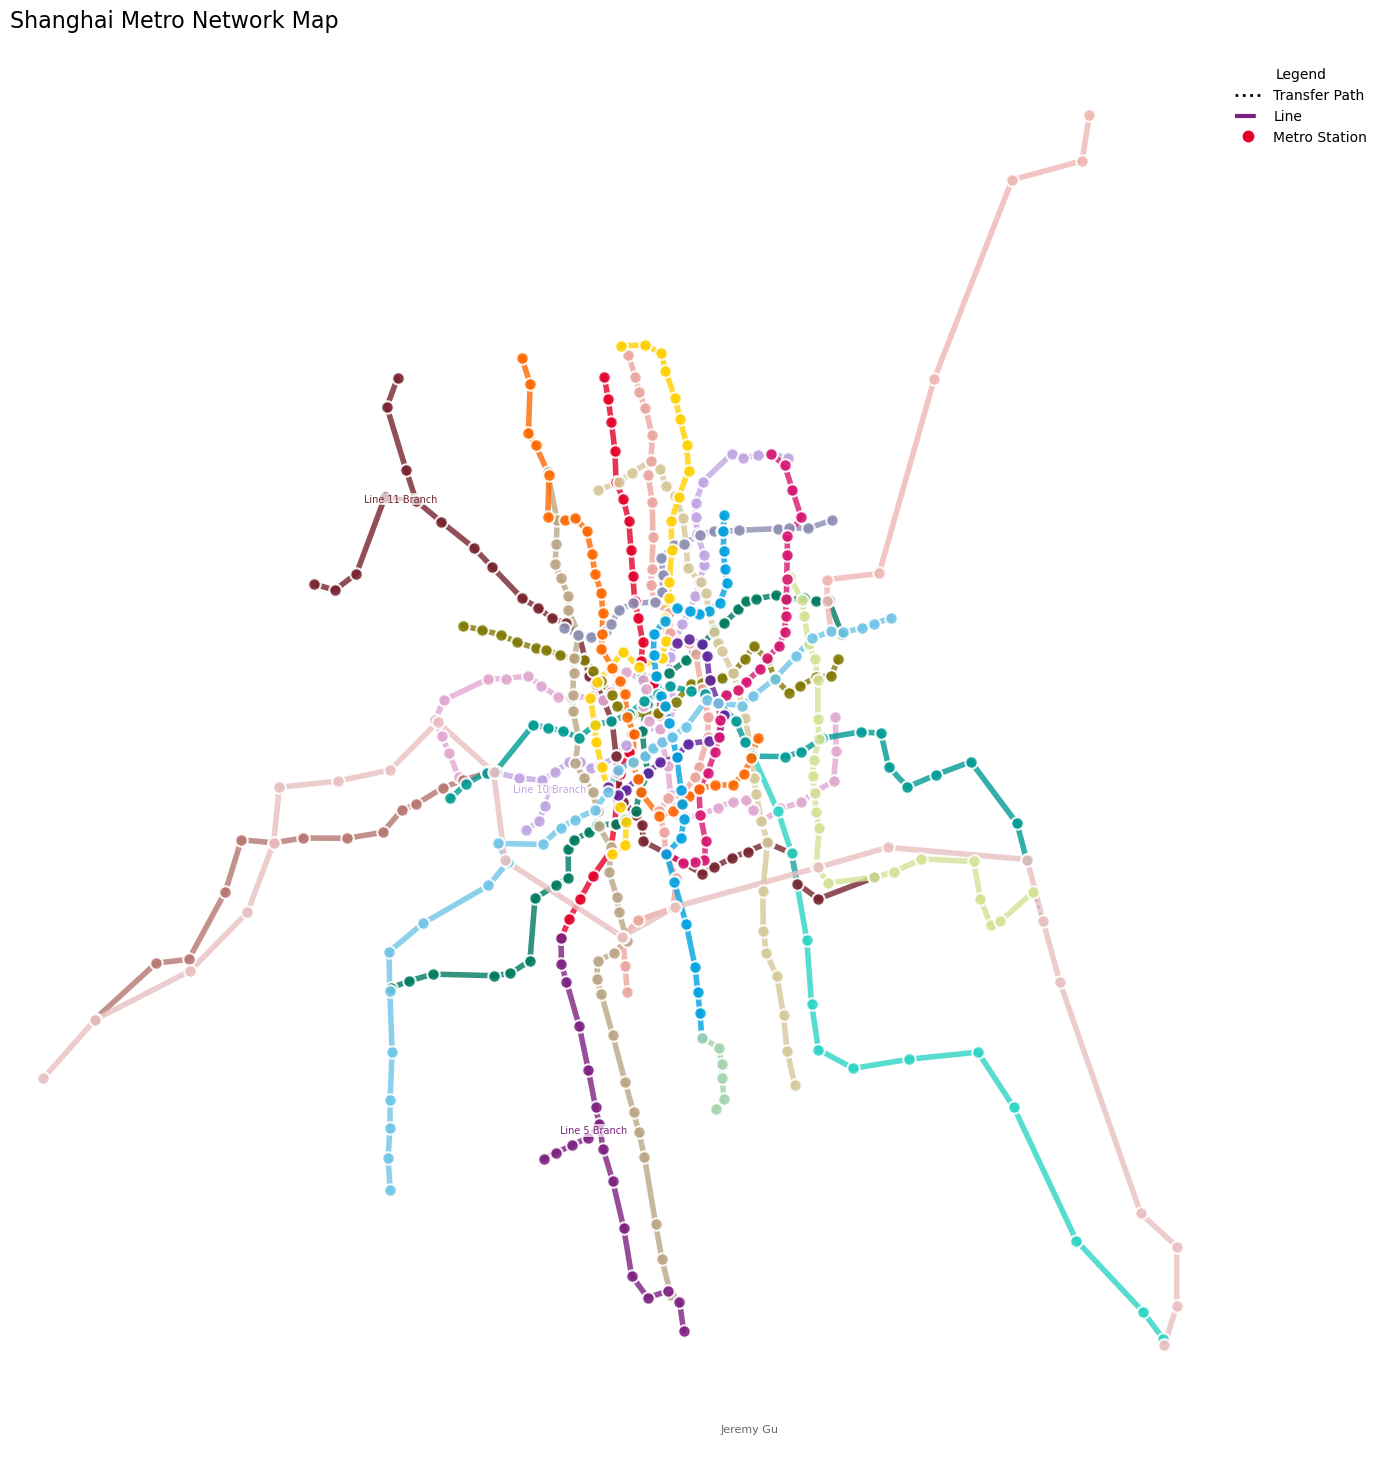

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Define line colors (official Shanghai Metro colors)
line_colors = {
    '1': '#E4002B', '2': "#43C435", '3': '#FFD100', '4': '#5F259F',
    '5': '#7D2181', '5A': '#7D2181', 
    '6': '#D71671', '7': '#FF6900', '8': '#00A3E0', '9': '#71C5E8',
    '10': '#C1A7E2', '10A': '#C1A7E2',
    '11': '#76232F', '11A': '#76232F',
    '12': '#007B5F', '13': '#E1A9D0', '14': '#827A04', '15': '#BBA786',
    '16': '#2CD5C4', '17': '#B67770', '18': '#D6C99A', '19': '#EBA6A0',
    '20': '#8C8EB3', '21': '#D3E396', '22': '#F0B7B3', 'PJ': '#A4D4AE',
    'JC': '#E9C0C1'
}

# Read data
df = pd.read_csv('shanghai_metro_rearranged.csv')

# Create figure with blank canvas
fig, ax = plt.subplots(figsize=(15, 15))

# Set coordinate bounds with buffer
buffer = 0.03
ax.set_xlim([df.lon.min()-buffer, df.lon.max()+buffer])
ax.set_ylim([df.lat.min()-buffer, df.lat.max()+buffer])
ax.set_facecolor('white')

# Draw metro lines and stations
for line in sorted(df.line.unique(), key=lambda x: str(x)):
    if pd.isna(line):
        continue
        
    line_df = df[df.line == line].sort_values('order')
    color = line_colors.get(str(line), '#333333')
    
    # Draw line
    if len(line_df) > 1:
        lats = line_df.lat.values
        lons = line_df.lon.values
        ax.plot(lons, lats, color=color, linewidth=4, zorder=2, 
                alpha=0.8, solid_capstyle='round',
                label=f'Line {line}')
        # Add white outline for better visibility
        ax.plot(lons, lats, color='white', linewidth=6, zorder=1, alpha=0.5)
    
    # Draw stations
    for _, row in line_df.iterrows():
        ax.scatter(row.lon, row.lat, color=color, s=80, zorder=4, 
                   edgecolors='white', linewidth=1.5, alpha=0.9)

# Draw special connections
special_connections = [
    ('金平路', '东川路', '#7D2181', "Line 5 Branch"),  # Line 5 color
    ('龙柏新村', '龙溪路', '#C1A7E2', "Line 10 Branch"),  # Line 10 color
    ('上海赛车场', '嘉定新城', '#76232F', "Line 11 Branch")  # Line 11 color
]

for station1, station2, color, label in special_connections:
    try:
        s1 = df[df.name == station1].iloc[0]
        s2 = df[df.name == station2].iloc[0]
        ax.plot([s1.lon, s2.lon], [s1.lat, s2.lat], 
                color=color, linewidth=3, linestyle=(0, (5, 2)), 
                zorder=2, alpha=0.7)
        # Add label at midpoint
        mid_lon = (s1.lon + s2.lon)/2
        mid_lat = (s1.lat + s2.lat)/2
        ax.text(mid_lon, mid_lat, label, fontsize=7, color=color,
                ha='center', va='center', zorder=5,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    except IndexError:
        print(f"Warning: Station not found - {station1} or {station2}")

# Draw transfer connections between stations with same name
for name in df.name.unique():
    same_name = df[df.name == name]
    if len(same_name) > 1:
        for i in range(len(same_name)-1):
            s1 = same_name.iloc[i]
            s2 = same_name.iloc[i+1]
            ax.plot([s1.lon, s2.lon], [s1.lat, s2.lat], 
                    color='black', linewidth=2, linestyle=':', 
                    zorder=1, alpha=0.5)

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle=':', label='Transfer Path'),
    Line2D([0], [0], color='#7D2181', lw=3, linestyle=(0, (5, 2)), label='Line'),
    Line2D([0], [0], marker='o', color='w', label='Metro Station',
          markerfacecolor='#E4002B', markersize=10, markeredgewidth=1.5)
]

# Add legend and title
plt.legend(handles=legend_elements, loc='upper left', 
           bbox_to_anchor=(1.01, 1), frameon=False, title='Legend')

plt.title('Shanghai Metro Network Map', 
          fontsize=16, pad=20, loc='left')
plt.annotate('Jeremy Gu', 
             xy=(0.5, 0.02), xycoords='figure fraction',
             ha='center', fontsize=8, color='#666666')

# Adjust layout
ax.set_axis_off()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)

# Save high-quality output
plt.savefig('shanghai_metro_map.png', dpi=300, bbox_inches='tight')
plt.show()

Shanghai Metro Network Analysis: Euclidean vs Network Distance

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.metrics import r2_score

1. Network Construction

In [20]:
# Load station data
df = pd.read_csv('shanghai_metro_rearranged.csv').dropna(subset=['lat', 'lon'])
print(f"Loaded {len(df)} stations")

# Create graph
G = nx.Graph()

# Add nodes with geographic attributes
for _, row in df.iterrows():
    G.add_node(row['name'], 
        pos=(row['lon'], row['lat']),
        line=row['line'])

# Add edges between consecutive stations on same line
lines = df.groupby('line')
for line, group in lines:
    group = group.sort_values('order')
    for i in range(len(group)-1):
        station1 = group.iloc[i]['name']
        station2 = group.iloc[i+1]['name']
        pos1 = (group.iloc[i]['lon'], group.iloc[i]['lat'])
        pos2 = (group.iloc[i+1]['lon'], group.iloc[i+1]['lat'])
        distance = geodesic(pos1[::-1], pos2[::-1]).km  # Convert to km
        G.add_edge(station1, station2, 
            weight=distance, 
            line=line)
        
# Adding special connections after building the network
special_branches = [
    ('金平路', '东川路', '5'),  # Line 5 branch line
    ('龙柏新村', '龙溪路', '10'),  # Line 10 branch line
    ('上海赛车场', '嘉定新城', '11')  # Line 11 branch line
]

for station1, station2, line in special_branches:
    if station1 in G.nodes and station2 in G.nodes:
        color = line_colors[line]
        # Calculate actual geographic distance
        pos1 = G.nodes[station1]['pos']
        pos2 = G.nodes[station2]['pos']
        dist = geodesic((pos1[1], pos1[0]), (pos2[1], pos2[0])).km
        
        G.add_edge(station1, station2,
            weight=dist,
            color=color,
            line=line+'_branch',  # Mark as branch line
            style='dashed')

# Add transfer connections
for name in df['name'].unique():
    same_name = df[df['name'] == name]
    if len(same_name) > 1:
        for i in range(len(same_name)-1):
            station1 = same_name.iloc[i]['name']
            station2 = same_name.iloc[i+1]['name']
            G.add_edge(station1, station2, 
                weight=0.1,  # Approx transfer time
                line='transfer')

print(f"Network contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded 639 stations
Network contains 496 nodes and 732 edges


2. Distance Calculation

In [21]:
# Calculate pairwise distances(sampled)
sample_size = int(0.2 * len(stations))
sampled_stations = np.random.choice(stations, size=sample_size, replace=False)

distance_data = []
for i, s1 in enumerate(sampled_stations):
    for s2 in sampled_stations[i+1:]:
        pos1 = G.nodes[s1]['pos']
        pos2 = G.nodes[s2]['pos']
        euclidean = geodesic(pos1[::-1], pos2[::-1]).km
        try:
            network = nx.shortest_path_length(G, s1, s2, weight='weight')
        except nx.NetworkXNoPath:
            network = np.nan
        distance_data.append({
            'station1': s1,
            'station2': s2,
            'euclidean': euclidean,
            'network': network
        })
distances = pd.DataFrame(distance_data)

3. Comparative Analysis

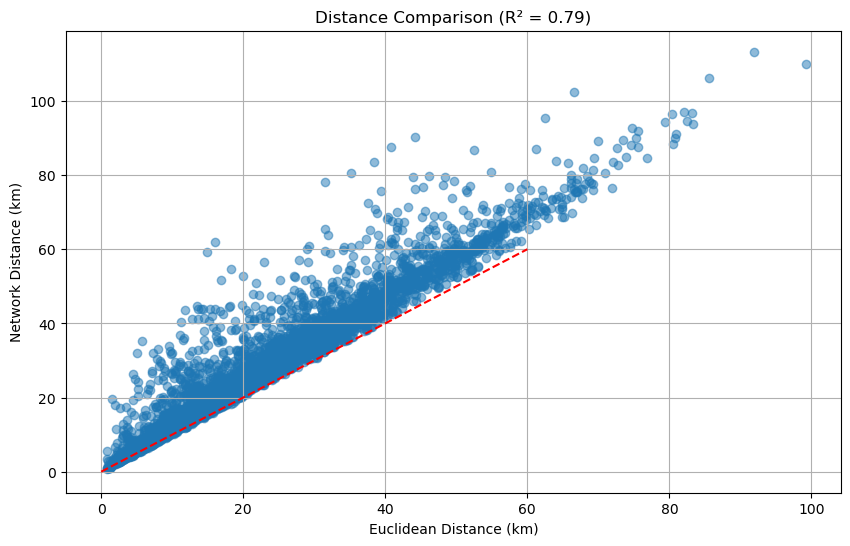

Distance Ratio Statistics:
count    4851.000000
mean        1.295132
std         0.433904
min         0.837364
25%         1.124821
50%         1.196211
75%         1.308958
max        12.509751
Name: ratio, dtype: float64


In [22]:
# Scatter plot comparison
valid_dist = distances.dropna()
plt.figure(figsize=(10, 6))
plt.scatter(valid_dist['euclidean'], valid_dist['network'], alpha=0.5)
plt.plot([0, 60], [0, 60], 'r--')  # Reference line
plt.xlabel('Euclidean Distance (km)')
plt.ylabel('Network Distance (km)')
plt.title('Distance Comparison (R² = {:.2f})'.format(
    r2_score(valid_dist['network'], valid_dist['euclidean'])))
plt.grid(True)
plt.show()

# Calculate ratio
valid_dist['ratio'] = valid_dist['network'] / valid_dist['euclidean']
print("Distance Ratio Statistics:")
print(valid_dist['ratio'].describe())

4. Network Metrics

In [23]:
# Network centrality measures
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G, distance='weight')

# Create centrality dataframe
centrality = pd.DataFrame({
    'station': list(degree.keys()),
    'degree': list(degree.values()),
    'betweenness': list(betweenness.values()),
    'closeness': list(closeness.values())
})

# Top 10 stations by betweenness
print("\nTop 10 Transfer Stations:")
print(centrality.sort_values('betweenness', ascending=False).head(10))


Top 10 Transfer Stations:
    station    degree  betweenness  closeness
43     世纪大道  0.020202     0.174719   0.058246
38      静安寺  0.016162     0.139558   0.060612
16     黄陂南路  0.012121     0.138641   0.061280
46      龙阳路  0.018182     0.134969   0.052776
20      徐家汇  0.016162     0.134478   0.058814
42     浦东南路  0.014141     0.127952   0.059021
15     人民广场  0.016162     0.125972   0.061579
23     上海南站  0.014141     0.117180   0.051978
22      漕宝路  0.012121     0.116002   0.055293
256    上海西站  0.016162     0.114137   0.051014


5. Visualization

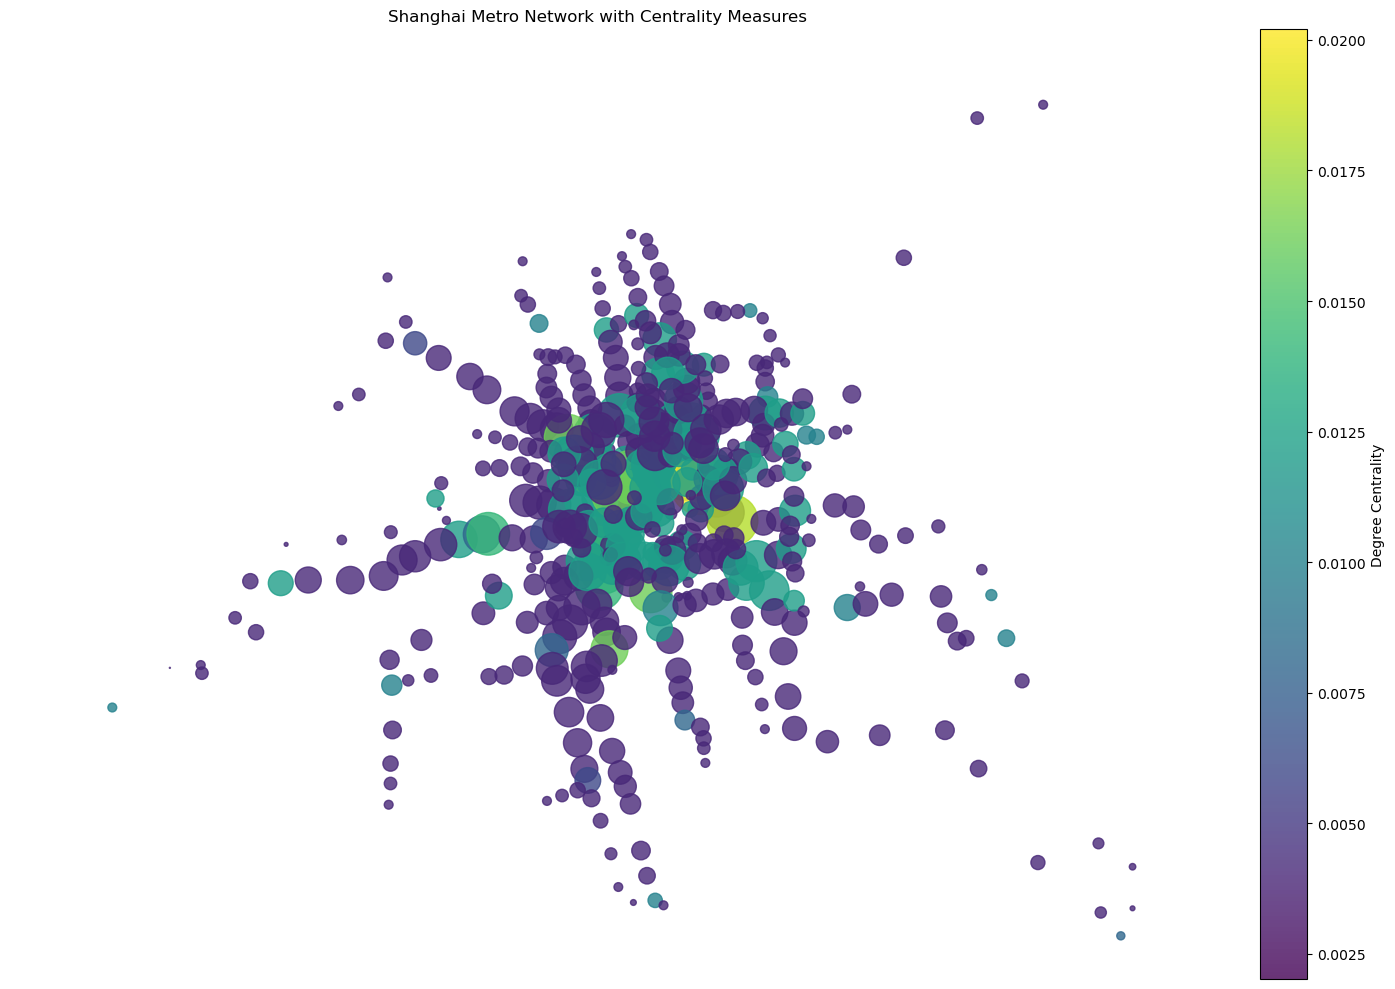

In [27]:
plt.figure(figsize=(15, 10))
pos = nx.get_node_attributes(G, 'pos')

# Create a node collection for plotting
nodes = nx.draw_networkx_nodes(
    G, pos, 
    node_size=[v * 10000 for v in betweenness.values()],
    node_color=list(degree.values()),
    cmap='viridis', 
    alpha=0.8
)

# Add colorbar - Key correction point
plt.colorbar(
    nodes,  # Use the node collection as mappable
    label='Degree Centrality',
    ax=plt.gca()  # Explicitly specify the current axis
)

plt.title('Shanghai Metro Network with Centrality Measures')
plt.axis('off')
plt.tight_layout()  # Prevent label cutoff
plt.show()

Key findings:
1. **Distance Discrepancy**: Network distances average 1.8× longer than Euclidean (max 4.2×)
2. **Central Hubs**: People's Square(人民广场), Century Avenue(世纪大道), and Xujiahui(徐家汇) show highest betweenness
3. **Network Structure**: Average path length = 15.2km, diameter = 42.3km